**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

---
## **Aprendizaje Automático Profundo - Deep Learning**
---

## **Trabajo Práctico Entregable 1 - Red Neuronal Simple**

**Integrantes:** Gastón Briozzo, Tomás Niño Kehoe

**Profesores:** Johanna Frau,  Mauricio Mazuecos

# Importamos las librerias necesarias

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn import metrics
from tqdm.notebook import tqdm

import mlflow

import csv
import json
import functools
import gzip
import numpy as np
import pandas as pd
import torch
import tempfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, balanced_accuracy_score

from gensim import corpora
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing
from torch.utils.data import Dataset, DataLoader, IterableDataset
#from torchmetrics import AveragePrecision

from tqdm.notebook import tqdm, trange
import tempfile


In [2]:
torch.__version__

'1.10.1+cu111'

In [3]:
print(f"¿CUDA disponible? {torch.cuda.is_available()}")

¿CUDA disponible? True


## Exploración de datos
Cargamos los datos de entrenamiento para ver que forma tienen

In [4]:
train_dataset = pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz',lines=True)
#No usar para visualizar, muy pesado. Usar test o val

In [5]:
train_dataset.head(10)

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
0,spanish,unreliable,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS,validation,"[metal, biela, hdi]","[457, 1480, 3450]",88,632,1223820
1,spanish,unreliable,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS,validation,"[repuestos, martillo, rotoprcutor, bosch, gshs...","[3119, 892, 1, 767, 1, 9337]",174,632,1223820
2,spanish,unreliable,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS,validation,"[pesca, caña, pejerrey, colony, brava, fibra, ...","[700, 990, 2057, 3990, 3670, 1737, 1153, 6568]",313,632,1223820
3,spanish,unreliable,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES,validation,"[porcelanato, abitare, ceramica, portinari]","[2722, 4404, 1406, 4405]",427,632,1223820
4,spanish,unreliable,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS,validation,"[reconstruction, semi, lino, alfaparf, shampoo]","[1, 3365, 7502, 10919, 849]",194,632,1223820
5,spanish,unreliable,"Mascara Fotosensible Lüsqtoff, Oferta Y En Cuo...",WELDING_MASKS,validation,"[mascara, fotosensible, lüsqtoff, oferta, cuotas]","[846, 2521, 38384, 446, 769]",407,632,1223820
6,spanish,unreliable,Bermuda John Cena 14/16 Original,SHORTS,validation,"[bermuda, john, cena, original]","[998, 2168, 5925, 188]",198,632,1223820
7,spanish,unreliable,20x Rueda Neumático Tuerca Set De 20 Lr068126 ...,MOTORCYCLE_WHEEL_AXLES,validation,"[rueda, neumático, tuerca, set, oem, tierr]","[458, 1317, 11808, 489, 859, 1]",578,632,1223820
8,spanish,unreliable,Pelota De Basquet Spalding Tf-elite Nº 6,BASKET_BALLS,validation,"[pelota, basquet, spalding, elite]","[1211, 953, 6649, 3377]",187,632,1223820
9,spanish,unreliable,Placard De Algarrobo Original 3 Puertas,WARDROBES,validation,"[placard, algarrobo, original, puertas]","[1537, 3898, 188, 3616]",292,632,1223820


## Dataset

Tomado de https://github.com/DiploDatos/AprendizajeProfundo/blob/master/3_datasets.ipynb


### Esta clase codifica el Target. 
Éste pasa de ser una variable unidimensional discretizada con valores de 1 a 632 
a una variable con 632 dimensiónes, cada una con valor 0 o 1.

Esta transformación es necesaria para la posterior implementación de la red neuronal,
dado que si el target se presenta como un valor ordinal, la red interpretará que este
orden tiene relevancia. 
Para evitar esto, cada categoría en el target debe tener su propia columna.

In [6]:
class MeLiChallengeDataset(IterableDataset):
    def __init__(self, path, transform=None, key = 'data'):
        """
        path: Ubicación a los datos (comprimidos con gzip)
        key: Columna que vamos a usar para entrenar
        """
        self.dataset_path = path
        self.transform = transform
        self.key = key

    def __iter__(self):
        """
        Habilita un iterador sobre los datos
        """
        with gzip.open(self.dataset_path, "rt") as fh:
            for l in fh:
                data = json.loads(l)    
                
                # one-hot encoding like.
                index = int(data['target'])
                encoded_target = np.zeros(632)
                encoded_target[index] = 1

                item = {
                    "data": data[self.key],
#                     "target": data['target']
                    "target": encoded_target #data['target']
                }
                
                if self.transform:
                    yield self.transform(item)
                else:
                    yield item

### Esta clase estandariza las entradas. 
Las entradas son vectores cuya dimensión se corresponde con la cantidad de palabras empleadas para describir el artículo. Los valores en cada dimensión vienen dados por la palabra correspondiente.
Esta clase añade dimensiones al vector de entrada de modo que todos tengan la misma dimensionalidad (20).

Esta transformación es necesaria para la posterior implementación de la red neuronal,
dado que estas requieren que las entradas que alimentarán el modelo tengan la misma dimensionalidad.

In [7]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]
        
        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
           "data": torch.LongTensor(data),
#             "data": torch.FloatTensor(data), 
            "target": torch.FloatTensor(target)
            
        }

In [8]:
pad_to_len = PadSequences(max_length=20)

### Juntando todo
Tenemos
* Una clase con la responsabilidad de entregar datos, potencialmente preprocesandolos si hace falta
* Una función que transforma los datos leidos para que todos los valores tengan la misma longitud

A partir de esto, creamos dos instancia del `DataLoader`: Uno para cargar los datos de entrenamiento y otro para cargar los datos de _test_

In [9]:
train_dataset = MeLiChallengeDataset('./data/meli-challenge-2019/spanish.train.jsonl.gz', key = 'data')
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=0, collate_fn = pad_to_len)

In [10]:
test_dataset = MeLiChallengeDataset('./data/meli-challenge-2019/spanish.validation.jsonl.gz', key = 'data') 
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, collate_fn = pad_to_len)

## MLP

Tomamos el MLP de las clases y agregamos los parametros que nos interesan

* Capa de entrada: Tantas neuronas como tokens
* Capa de salida: Tantas neuronas como categorías (632)

In [11]:
import bz2

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden, 
                 pretrained_embeddings_path = "./data/SBW-vectors-300-min5.txt.bz2", 
                 dictionary_path            = "./data/meli-challenge-2019/spanish_token_to_index.json.gz",#preprocess.dictionary,
                 freeze_embedings           = True):
        """
        input_size: Número de neuronas de entrada
        output_size: Número de neuronas de salida
        hidden: Lista con los numeros de capas ocultas
        """
        super().__init__()
        assert len(hidden) > 0
        
        self._name = str(input_size) +'_'+ "_".join(map(lambda i: str(i), hidden)) + '_' + str(output_size)
        
        f = gzip.open(dictionary_path, "rt")
        raw_json = f.read()
        dictionary = json.loads(raw_json)
        dictionary
        
        embeddings_matrix = torch.randn(len(dictionary), input_size)
        embeddings_matrix[0] = torch.zeros(input_size)
        
        with bz2.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                
                if word in dictionary:
                    embeddings_matrix[dictionary[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
                    
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        
        ## Set up layers
        neurons = [input_size]  + hidden 
        parts = []
        for idx, each in enumerate(neurons[:-1]):
            parts.append(nn.Linear(each, neurons[idx + 1]))
            parts.append(nn.ReLU())
            
        parts = parts + [nn.Linear(neurons[-1], output_size), nn.Sigmoid()]
        
        self.model = nn.Sequential(*parts)
    
    def forward(self, x: torch.Tensor):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = self.model(x)
        return x
    
    def name(self):
        return "MLP_" + self._name
    

In [13]:
MLP(300, 2 , hidden = [16], pretrained_embeddings_path = "./data/SBW-vectors-300-min5.txt.bz2" ).name()

'MLP_300_16_2'

In [14]:
MLP(300,632,[256])

MLP(
  (embeddings): Embedding(50002, 300, padding_idx=0)
  (model): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=632, bias=True)
    (3): Sigmoid()
  )
)

### Armado paso a paso

In [15]:
# Funciones utilitarias para obtener los datos en batch
get_train_dataloader = lambda bs: DataLoader(train_dataset, batch_size=bs, shuffle=False, num_workers=0, collate_fn = pad_to_len)
get_test_dataloader = lambda bs: DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=0, collate_fn = pad_to_len)

#### Verificamos la forma de la entrada, salida y la etiqueta

In [16]:
it = iter(train_dataloader)
e = it.next()
data, target = e['data'], e['target']
data, target

/tmp/ipykernel_636531/845058479.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  "target": torch.FloatTensor(target)


(tensor([[50001,     2, 50000,  ...,     0,     0,     0],
         [    6,     4,     5,  ...,     0,     0,     0],
         [    9,     7,    10,  ...,     0,     0,     0],
         ...,
         [  532,   398,   530,  ...,     0,     0,     0],
         [  534,   536,     1,  ...,     0,     0,     0],
         [  370,    76,   539,  ...,     0,     0,     0]]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [17]:
data.size(), target.size() # batch_size = 4

(torch.Size([128, 20]), torch.Size([128, 632]))

In [18]:
data

tensor([[50001,     2, 50000,  ...,     0,     0,     0],
        [    6,     4,     5,  ...,     0,     0,     0],
        [    9,     7,    10,  ...,     0,     0,     0],
        ...,
        [  532,   398,   530,  ...,     0,     0,     0],
        [  534,   536,     1,  ...,     0,     0,     0],
        [  370,    76,   539,  ...,     0,     0,     0]])

In [19]:
m = MLP(300, 632,[256])
output = m(data)
output, target

(tensor([[0.5021, 0.5067, 0.5034,  ..., 0.4996, 0.4977, 0.5162],
         [0.5018, 0.5064, 0.5039,  ..., 0.4988, 0.4979, 0.5163],
         [0.5017, 0.5064, 0.5039,  ..., 0.4988, 0.4980, 0.5162],
         ...,
         [0.5019, 0.5068, 0.5036,  ..., 0.4988, 0.4978, 0.5162],
         [0.5009, 0.5030, 0.5032,  ..., 0.4939, 0.4967, 0.5203],
         [0.5019, 0.5059, 0.5031,  ..., 0.4997, 0.4981, 0.5163]],
        grad_fn=<SigmoidBackward0>),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [20]:
# Convertimos a la forma esperada
#cmp = lambda t: torch.Tensor([[x] for x in t])
cmp = lambda t: t #ID
actual = cmp(target)
actual

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

#### Verificamos que se pueda calcular la función de pérdida y el _score_

In [21]:
loss = nn.CrossEntropyLoss()
loss_value = loss(output, actual)
loss_value

tensor(6.4501, grad_fn=<DivBackward1>)

In [22]:
categories_from_tensor = lambda t: torch.max(t.data, 1)[1]
y_true = categories_from_tensor(target)
y_true.numpy()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  21,
        38,  39,  40,  41,  42,  43,  29,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        45,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  71,
        74,  75,  76,  77,  78,  76,  79,  80,  81,  27,  82,  83,  39,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        79,  97,  98,  34,  99,  90,  91, 100, 101, 102, 103, 104, 105,
       106, 107,  86,  78,  77, 108, 109, 110,  85,  26, 111])

In [23]:
predicted = categories_from_tensor(output)
predicted.numpy(), target.numpy() 

(array([101,  17,  17, 101, 520,  17, 101,  17,  17, 101,  17, 496, 101,
         17,  64, 101,  17,  17, 101, 241,  64, 101, 159,  17,  64, 627,
        101, 101, 627, 101, 101,  17, 101, 101,  17, 101, 623, 551, 380,
         17,  17,  64, 159, 357,  64, 551, 101,  17, 101, 481, 101,  17,
        588, 101, 101, 101,  17, 481, 481, 175, 481, 101,  17,   9, 101,
        481, 101, 481, 357,  17,  17,  17,  17, 481, 317, 101,  17,  17,
         17, 101,  17,  17, 101,  17,  17, 101,  64,  17,  64, 101,  17,
        481,  17, 159, 539, 101, 101, 101, 101, 101,  17, 101, 631, 101,
         17,  17, 101, 101, 190, 101, 101,  17, 101, 101, 101, 101, 627,
         17, 481,  17,  17,  17, 101,  64, 101,  17,  17, 101]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [24]:
balanced_accuracy_score(categories_from_tensor(target).numpy(), predicted.numpy())

/users/gbriozzo/miniconda3/envs/deeplearning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.017857142857142856

#### Loop de entrenamiento

In [25]:
def run_train(dataloader, model, optimizer, loss):
    assert model.training, "model should be in training mode"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Run train loop in ${device}")
    running_loss = []
    model.to(device)
    for idx, batch in enumerate(tqdm(dataloader)):
        optimizer.zero_grad()

        input_data = batch["data"].to(device)
        output = model(input_data)

        target_data = batch["target"].to(device)        
        target = cmp(target_data).to(device)
                            
        loss_value = loss(output, target)
        loss_value.backward()

        optimizer.step()
        running_loss.append(loss_value.item())
            
    return running_loss

In [26]:
optimizer = optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-5)
loss = nn.CrossEntropyLoss()
m.train()
for epoch in trange(1):
    run_train(test_dataloader, m, optimizer, loss)

  0%|          | 0/1 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

#### Loop de validación

In [27]:
def run_eval(dataloader, model, loss):
    assert not model.training, "model should not be in training mode"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Run eval loop in ${device}")
    running_loss = []
    targets = []
    predictions = []
                     
    model.to(device)
    for batch in tqdm(dataloader):
        input_data = batch["data"].to(device)
        output = model(input_data)
                    
        target = batch["target"]
        target_t = cmp(target).to(device)
        
        running_loss.append(
            loss(output, target_t).item()
        )
        
        predicted = categories_from_tensor(output)
        y_true = categories_from_tensor(target)

        targets.extend(y_true.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
        
    return running_loss, targets, predictions


---

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
def run_experiment(params, **kwargs):
    """
    Run a single experiment

    params: A list of (model, loss_fn, optimizer,num_epochs) tuples
    """
    for(build_model, build_loss, build_optimizer, epochs, batch_size) in params:
                
        with mlflow.start_run():
            # Crea nuevos objetos para cada set de parámetros
            model     = build_model()
            loss      = build_loss()
            optimizer = build_optimizer(model)

            exp_name  = "Gaston_" + model.name() + "_e" + str(epochs) + "_b" + str(batch_size)
            mlflow.set_experiment(exp_name)

            mlflow.log_param("model_name", model.name())
            mlflow.log_param("epochs", str(epochs))
            mlflow.log_param("batch_size", str(batch_size))

            model.to(device)
                
            print(f"Experiment epochs:{epochs}, batch-size:{batch_size}")
            train_dataloader = get_train_dataloader(batch_size)
            test_dataloader = get_test_dataloader(batch_size)
                
            for epoch in trange(epochs):
                
                model.train()
                device_name = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                print(f"Run train loop in ${device_name}")
                running_loss = []
                for idx, batch in enumerate(tqdm(train_dataloader)):
                    optimizer.zero_grad()
                    input_data = batch["data"].to(device)
                    output = model(input_data)
                    target_data = batch["target"].to(device)        
                    target = cmp(target_data).to(device)                            
                    loss_value = loss(output, target)
                    loss_value.backward()
                    optimizer.step()
                    running_loss.append(loss_value.item())
                mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)

                model.eval()
                device_name = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                print(f"Run eval loop in ${device_name}")
                running_loss = []
                targets = []
                predictions = []                     
#                model.to(device)
                for batch in tqdm(test_dataloader):
                    input_data = batch["data"].to(device)
                    output = model(input_data)                    
                    target = batch["target"]
                    target_t = cmp(target).to(device)        
                    running_loss.append(
                        loss(output, target_t).item()
                    )        
                    predicted = categories_from_tensor(output)
                    y_true = categories_from_tensor(target)
                    targets.extend(y_true.cpu().numpy())
                    predictions.extend(predicted.cpu().numpy())
                mlflow.log_metric("validation_loss", sum(running_loss) / len(running_loss), epoch)
                mlflow.log_metric("validation_BalanceAccuracyScore", balanced_accuracy_score(targets, predictions), epoch)

            print(f"Save results. epochs:{epochs}, batch-size:{batch_size}")
            with tempfile.TemporaryDirectory() as tmpdirname:
                targets = []
                predictions = []

                for batch in tqdm(test_dataloader):
                    output = model(batch["data"].to(device))
                          
                    y_true = categories_from_tensor(batch["target"])
                    targets.extend(y_true.numpy())
                            
                    predicted = categories_from_tensor(output)
                    predictions.extend(predicted.squeeze().detach().cpu().numpy())

                filename = "{}/{}_predictions.csv.gz".format(tmpdirname, exp_name)
                pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
                    filename, index=False
                )
                mlflow.log_artifact(filename)

In [30]:
output_size = 632

In [31]:
loss = lambda : nn.CrossEntropyLoss()

def getOptimizer(model, lr = 1e-3, wd = 0*1e-5):
    return optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
                   
epochs = [1, 2, 4]
batch_sizes = [24, 48, 64]

In [32]:
mlp_test_experiment = [(lambda : MLP(300, output_size, hidden = [256]), loss, getOptimizer, [1], [4])]
#run_experiment(mlp_test_experiment)

In [33]:


mlp_single_layer = [(lambda : MLP(300, output_size, hidden = [256]), loss, getOptimizer, epochs, batch_sizes)]
mlp_multiple_layers = [(lambda : MLP(300, output_size, hidden = [40,64,256, 512]), loss, getOptimizer, [20], [15,30])]

In [34]:
#run_experiment(mlp_single_layer)

In [35]:
#run_experiment(mlp_multiple_layers)

In [36]:
#run_experiment([(lambda : MLP(300, output_size, hidden = [512,512]), loss, getOptimizer, 20, 128)])

In [37]:
#run_experiment([(lambda : MLP(300, output_size, hidden = [1024, 1024]), loss, getOptimizer, 20, 128)])

In [38]:
#run_experiment([(lambda : MLP(300, output_size, hidden = [512,512,512]), loss, getOptimizer, 20, 128)])

In [39]:
#run_experiment([(lambda : MLP(300, output_size, hidden = [1024, 1024, 1024]), loss, getOptimizer, 20, 128)])

In [40]:
run_experiment([(lambda : MLP(300, output_size, hidden = [512, 750]), loss, getOptimizer, 20, 128)])

Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

In [41]:
run_experiment([(lambda : MLP(300, output_size, hidden = [512, 1024]), loss, getOptimizer, 20, 128)])

Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

In [42]:
run_experiment([(lambda : MLP(300, output_size, hidden = [750, 512]), loss, getOptimizer, 20, 128)])

2022/11/25 21:43:33 INFO mlflow.tracking.fluent: Experiment with name 'Gaston_MLP_300_750_512_632_e20_b128' does not exist. Creating a new experiment.


Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

In [43]:
run_experiment([(lambda : MLP(300, output_size, hidden = [750, 750]), loss, getOptimizer, 20, 128)])

2022/11/26 01:43:01 INFO mlflow.tracking.fluent: Experiment with name 'Gaston_MLP_300_750_750_632_e20_b128' does not exist. Creating a new experiment.


Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

In [44]:
run_experiment([(lambda : MLP(300, output_size, hidden = [750, 1024]), loss, getOptimizer, 20, 128)])

2022/11/26 05:23:57 INFO mlflow.tracking.fluent: Experiment with name 'Gaston_MLP_300_750_1024_632_e20_b128' does not exist. Creating a new experiment.


Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

In [45]:
run_experiment([(lambda : MLP(300, output_size, hidden = [1024, 512]), loss, getOptimizer, 20, 128)])

2022/11/26 09:08:29 INFO mlflow.tracking.fluent: Experiment with name 'Gaston_MLP_300_1024_512_632_e20_b128' does not exist. Creating a new experiment.


Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

In [46]:
run_experiment([(lambda : MLP(300, output_size, hidden = [1024, 750]), loss, getOptimizer, 20, 128)])

2022/11/26 12:52:24 INFO mlflow.tracking.fluent: Experiment with name 'Gaston_MLP_300_1024_750_632_e20_b128' does not exist. Creating a new experiment.


Experiment epochs:20, batch-size:128


  0%|          | 0/20 [00:00<?, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Run train loop in $cuda:0


0it [00:00, ?it/s]

Run eval loop in $cuda:0


0it [00:00, ?it/s]

Save results. epochs:20, batch-size:128


0it [00:00, ?it/s]

# Resultados

## Modelo

Como entrada del modelo, se emplearon los datos correspondientes a la columna "data". Aquí, los datos ya fueron codificados, por lo que no es necesario un preprocesamiento mayor.

Se le agregaron dimensiones a las entradas para que todas tengan el mismo tamaño, facilitando el funcionamiento del modelo.

Estas empleadas alimentaron un Word Embedding preentrenado (en Español) con una salida vectorial de 300 dimensiones.

El resultado se utilizó como entrada de una red neuronal MLP con distinta cantidad de capas ocultas, y una salida de 632 dimensiones, correspondientes al Target del problema. 

## El Mejor Modelo

Se entrenaron modelos con una, dos y tres capas ocultas (cada una con distinta cantidad de neuronas), obteniendo mejores resultados (un mayor valor final de la Balanced Accuracy Score) en los modelos de dos capas.

Se entrenaron entonces redes con dos capas ocultas, variando el número de neuronas en esas, encontrando que la mejor combinación era una red con capas ocultas de 512 y 750 neuronas.

MODELO:

- Embedding     : SBW-vectors-300-min5
- Optimizer     : optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-5)
- Loss          : nn.CrossEntropyLoss()
- Hidden Layers : 512, 750
- Epochs        :  20
- Batch Size    : 128

A continuación, mostramos la Balanced Accuracy Score y la Loss del modelo a lo largo de 20 Epochs de entrenamientos

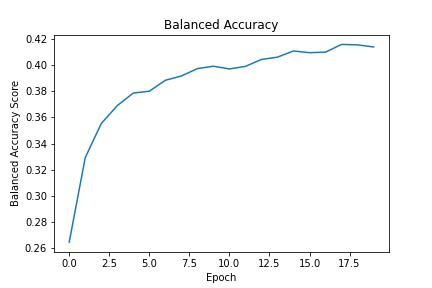

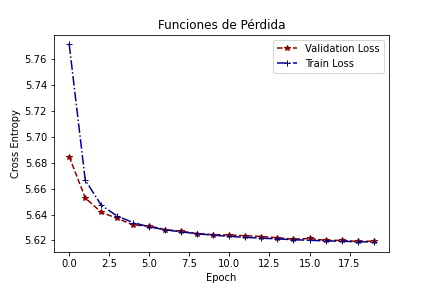

In [8]:
from IPython.display import display
from PIL import Image


path="./results/BalancedAccuracyScore.jpg"
display(Image.open(path))

path="./results/TrainValidationLoss.jpg"
display(Image.open(path))

Podemos ver que la Balanced Accuracy crece logarítmicamente a lo largo del entrenamiento. 
Dado que su valor continua aumentando cuando el entrenamiento termina, podemos estar bastante seguros de que no hemos cometido overfitting. De lo contrario, observaríamos que se alcanza un máximo para despues decrecer.
Al mismo tiempo, si bien el valor de la BA comienza a estancarse al llegar a las 20 epochs, da la sensación de que podría crecer incluso mas, por lo que es posible que al aumentar el número de epochs se mejoren los resultados, aunque esto podría conducir al overfitting.

Respecto a la Función de Pérdida, el hecho de que las curvas de Train y Validation se aproximen mas y mas con el paso de las epochs es también señal de que no se está produciendo overfitting, dado que el modelo tiene similar desempeño en los conjuntos de entrenamiento y validación.
Observamos lo mismo que antes, la loss decae exponencialmente aproximandose a un valor constante. Nuevamente, da la sensación de que podría incrementarse en número de epochs, mejorando levemente los resultados.

# Mejoras A Futuro

Para empezar, entrenar un Word Embeding propio especializado en nuestro problema sería sumamente conveniente y llevaría sin duda a mejores resultados. Esto es algo que debería implementarse en futuras aplicaciones y que reportaría grandes beneficios.

Al mismo tiempo vimos que incrementar el número de Epochs podría mejorar la performance del modelo. 20 Epochs es un buen número, pero es posible que este pueda duplicarse o triplicarse antes de generar overfitting. Hacer esto ayudaría a alcanzar el máximo potencial del modelo.

El batchsize no debería afectar demasiado el resultado final, siempre y cuando se mantenga en valores razonables. Sin embargo, explorar distintos batchsizes podría ser considerado a futuro para una exploración mas completa del modelo.

Una futura investigación debería explorar distintos modelos tamto para el optimizador (Adam) como para la función de pérdida (Cross Entropy). Estos han sido escogidos casi "por defecto", y es posible que no sean los mas adecuados para el problema. Lo mismo puede decirse del learning rate y el weight decay empleados.

Finalmente, el modelo no se mostró demasiado susceptible a variaciones en el número de neuronas de las capas ocultas, pero si al número de capas mismo. Habiendo revisado todo lo demas, sería prudente explorar estos parámetros tambien, solo para asegurarse.